In [ ]:
# Notwendige Bibliotheken importieren
%pip install numpy librosa matplotlib scikit-learn scipy

/var/folders/3p/00fys0v91nv0c3gjwlnx9np00000gn/T/ipykernel_91433/3212752418.py:14: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=8000)


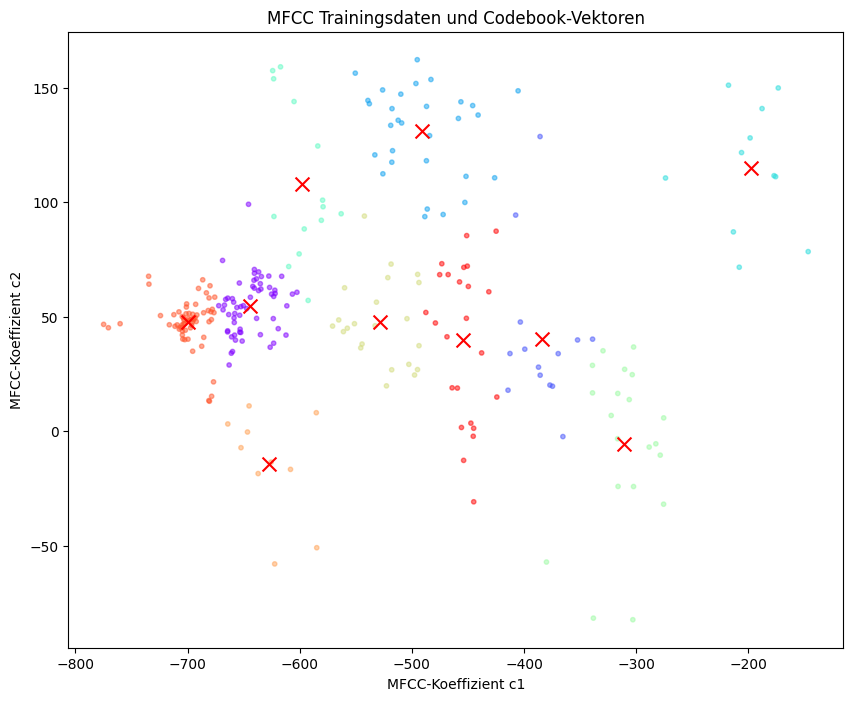

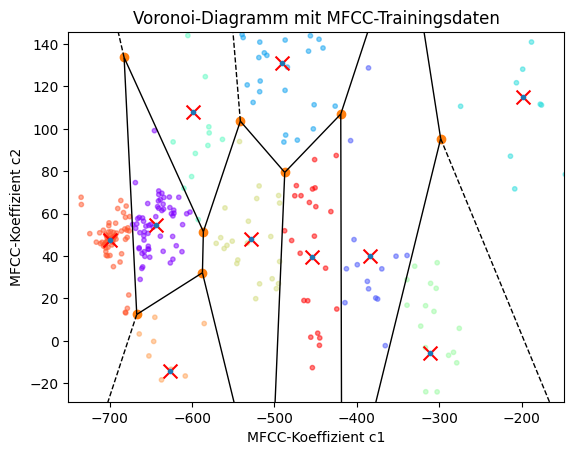

Relative Anzahl der Trainingsvektoren pro Voronoi-Bereich:
Codebook-Vektor 1: 0.2230
Codebook-Vektor 2: 0.0520
Codebook-Vektor 3: 0.1115
Codebook-Vektor 4: 0.0409
Codebook-Vektor 5: 0.0520
Codebook-Vektor 6: 0.0743
Codebook-Vektor 7: 0.0818
Codebook-Vektor 8: 0.0372
Codebook-Vektor 9: 0.2379
Codebook-Vektor 10: 0.0892
Der nächste Code-Vektor für den Eingabe-Vektor ist: 5
Zuordnung der Codebook-Nummern zu Lauten: {0: 3, 1: 2, 2: 9, 3: 1, 4: 1, 5: 3, 6: 2, 7: 10, 8: 5, 9: 1}
Erkannte Laute für a.m4a: [1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 9, 1, 1, 1, 1, 1, 1]


/var/folders/3p/00fys0v91nv0c3gjwlnx9np00000gn/T/ipykernel_91433/3212752418.py:14: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=8000)
/opt/homebrew/Cellar/jupyterlab/4.1.6/libexec/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


In [2]:

import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial import Voronoi, voronoi_plot_2d

# Laute und ihre entsprechenden Labels definieren
sounds = ['a', 'e', 'f', 'i', 'l', 'm', 'n', 'o', 's', 'u']
labels = {sound: i+1 for i, sound in enumerate(sounds)}

# Funktion zum Extrahieren der MFCC-Features aus Audiodateien
def extract_mfcc(file_path, n_mfcc=2):
    y, sr = librosa.load(file_path, sr=8000)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return mfccs.T

# 1)
# MFCCs aus allen Audiodateien extrahieren 
mfcc_features = []
mfcc_labels = []

for sound in sounds:
    file_path = f'{sound}.m4a'
    mfcc = extract_mfcc(file_path)
    mfcc_features.append(mfcc)
    mfcc_labels.extend([labels[sound]] * mfcc.shape[0])

mfcc_features = np.vstack(mfcc_features)

# K-Means Clustering durchführen 
k = 10
kmeans = KMeans(n_clusters=k, random_state=0).fit(mfcc_features)
codebook = kmeans.cluster_centers_
labels = kmeans.labels_

# Trainingsdaten und Codebook-Vektoren plotten 
plt.figure(figsize=(10, 8))
plt.scatter(mfcc_features[:, 0], mfcc_features[:, 1], c=labels, cmap='rainbow', s=10, alpha=0.5)
plt.scatter(codebook[:, 0], codebook[:, 1], c='red', marker='x', s=100)
plt.title('MFCC Trainingsdaten und Codebook-Vektoren')
plt.xlabel('MFCC-Koeffizient c1')
plt.ylabel('MFCC-Koeffizient c2')
plt.show()

# 2)
# Voronoi-Diagramm plotten 
vor = Voronoi(codebook)
fig = voronoi_plot_2d(vor)
plt.scatter(mfcc_features[:, 0], mfcc_features[:, 1], c=labels, cmap='rainbow', s=10, alpha=0.5)
plt.scatter(codebook[:, 0], codebook[:, 1], c='red', marker='x', s=100)
plt.title('Voronoi-Diagramm mit MFCC-Trainingsdaten')
plt.xlabel('MFCC-Koeffizient c1')
plt.ylabel('MFCC-Koeffizient c2')
plt.show()

# Relative Anzahl der Trainingsvektoren pro Voronoi-Bereich bestimmen 
unique, counts = np.unique(labels, return_counts=True)
relative_counts = counts / len(labels)

print("Relative Anzahl der Trainingsvektoren pro Voronoi-Bereich:")
for i, count in enumerate(relative_counts):
    print(f"Codebook-Vektor {i + 1}: {count:.4f}")

# 3)
# Funktion zur Bestimmung des nächsten Code-Vektors für einen Eingabe-Vektor 
def find_closest_code_vector(input_vector, codebook):
    distances = np.linalg.norm(codebook - input_vector, axis=1)
    return np.argmin(distances)

# Beispielhafte Verwendung von find_closest_code_vector 
input_vector = mfcc_features[0]
closest_vector_index = find_closest_code_vector(input_vector, codebook)
print(f"Der nächste Code-Vektor für den Eingabe-Vektor ist: {closest_vector_index + 1}")

# 4)
# Sicherstellen, dass mfcc_labels ein numpy Array von Integern ist 
mfcc_labels = np.array(mfcc_labels, dtype=int)

# Funktion zur Zuordnung der Codebook-Nummern zu einzelnen Lauten 
def map_codebook_to_sounds(mfcc_features, labels, codebook):
    sound_mapping = {}
    for i, code_vector in enumerate(codebook):
        indices = np.where(labels == i)[0]
        if len(indices) > 0:
            sound_label = np.bincount(mfcc_labels[indices]).argmax()
            sound_mapping[i] = sound_label
    return sound_mapping

sound_mapping = map_codebook_to_sounds(mfcc_features, labels, codebook)
print("Zuordnung der Codebook-Nummern zu Lauten:", sound_mapping)

#5)
# Funktion zur Erkennung von Lauten aus Audiodaten 
def recognize_sound(file_path, codebook, sound_mapping):
    mfcc = extract_mfcc(file_path)
    recognized_sounds = []
    for vector in mfcc:
        closest_vector_index = find_closest_code_vector(vector, codebook)
        recognized_sounds.append(sound_mapping[closest_vector_index])
    return recognized_sounds

# Erkennung von Lauten für eine Beispieldatei 
sample_file_path = 'a.m4a'
recognized_sounds = recognize_sound(sample_file_path, codebook, sound_mapping)
print(f"Erkannte Laute für {sample_file_path}: {recognized_sounds}")
